# Question 3

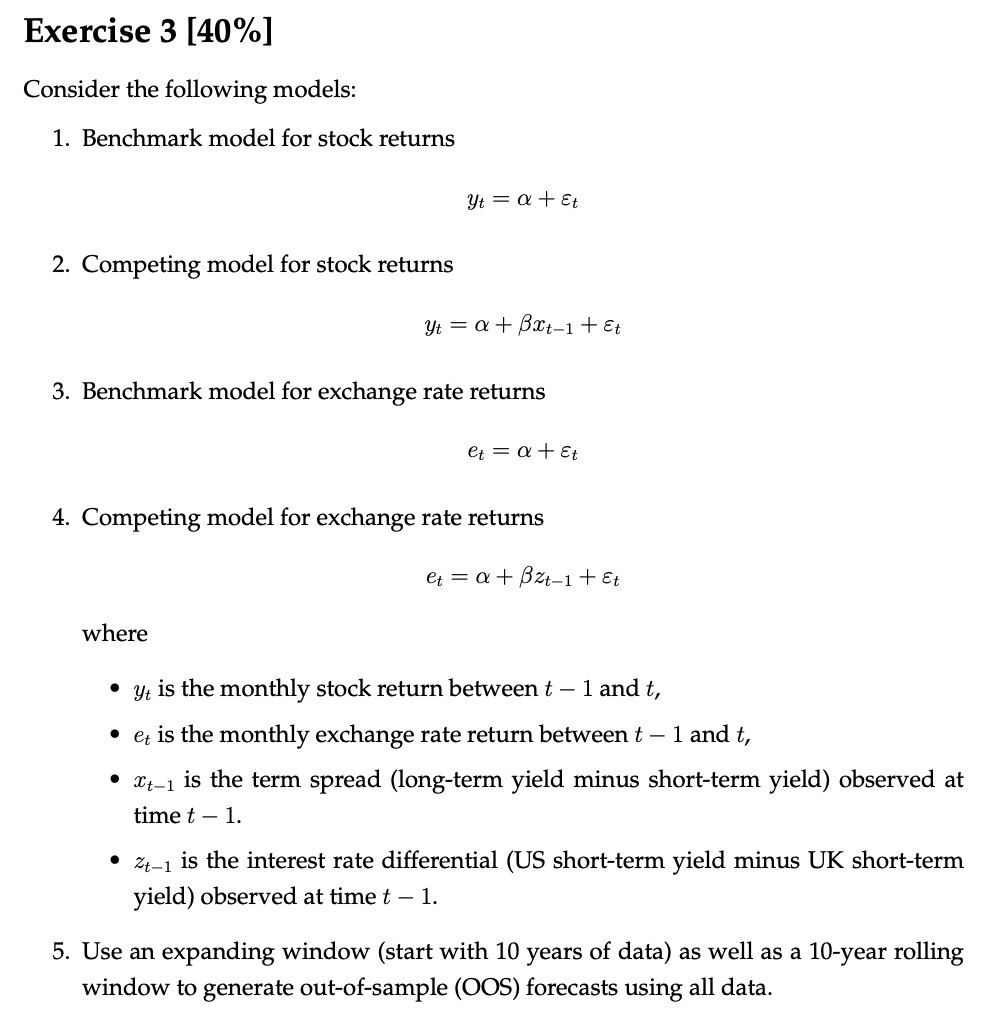

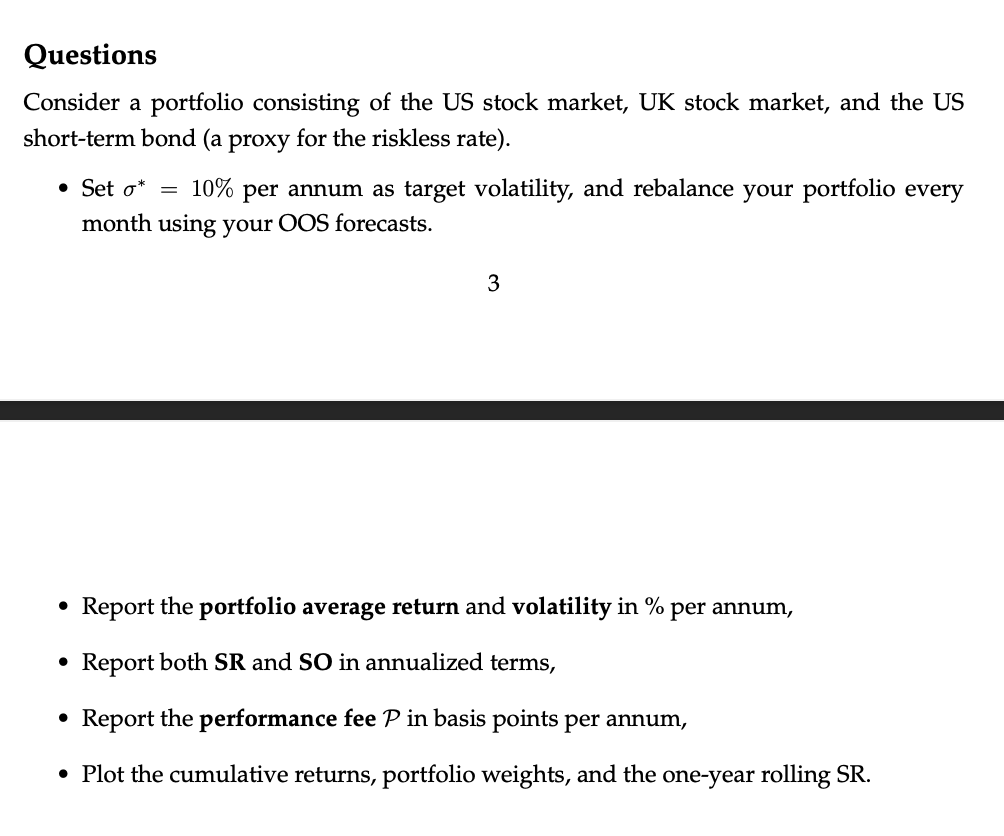

# Import Data

In [83]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import statsmodels.api as sm 
from datetime import datetime as dt
import yfinance as yf
from scipy.optimize import minimize

In [62]:
us_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
us_data = pd.read_excel(us_data_path, sheet_name='US')
us_data['Date'] = pd.to_datetime(us_data['Date'], dayfirst=True)
us_data["Log Returns"] = np.log(us_data['Stock Index'] / us_data['Stock Index'].shift(1))
us_data['Term Spread'] = us_data['Long-term Yield'].shift(1) - us_data['Short-term Yield'].shift(1)
us_data.dropna(inplace=True)
us_data.reset_index(drop = True, inplace=True)
us_data.head()

,Date,Stock Index,Short-term Yield,Long-term Yield,Log Returns,Term Spread
0,1792-02-29,2.496140,4.198,4.198,0.060760,0.0
1,1792-03-31,2.297596,4.940,4.940,-0.082882,0.0
2,1792-04-30,2.350072,5.143,5.143,0.022583,0.0
3,1792-05-31,2.562141,4.557,4.557,0.086397,0.0
4,1792-06-30,2.512370,4.675,4.675,-0.019617,0.0


In [63]:
# UK Data
uk_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
uk_data = pd.read_excel(uk_data_path, sheet_name='UK')
uk_data['Date'] = pd.to_datetime(uk_data['Date'], dayfirst=True)
uk_data["Log Returns"] = np.log(uk_data['Stock Index'] / uk_data['Stock Index'].shift(1))
uk_data["FX Returns"] = np.log(uk_data['FX rate'] / uk_data['FX rate'].shift(1))
uk_data['Term Spread'] = uk_data['Long-term Yield'].shift(1) - uk_data['Short-term Yield'].shift(1)
uk_data.dropna(inplace=True)
uk_data.reset_index(drop = True, inplace=True)
uk_data['Interest Rate Differential'] = us_data['Short-term Yield'] - uk_data['Short-term Yield']
uk_data.head()

,Date,Stock Index,Short-term Yield,Long-term Yield,FX rate,Log Returns,FX Returns,Term Spread,Interest Rate Differential
0,1792-02-29,10.842223,3.80,3.121,4.5620,0.050124,0.007260,-0.607,0.398
1,1792-03-31,10.952050,3.79,3.109,4.1169,0.010079,-0.102661,-0.679,1.150
2,1792-04-30,10.451244,3.79,3.230,4.3215,-0.046806,0.048502,-0.681,1.353
3,1792-05-31,10.358707,3.80,3.213,4.1615,-0.008894,-0.037727,-0.560,0.757
4,1792-06-30,10.403753,3.80,3.235,4.5106,0.004339,0.080555,-0.587,0.875


# Models

### US Stock Returns - Expanding Window

In [64]:
# Expanding Window Regression
expanding_model_prediction_US = []
expanding_benchmark_prediction_US = []
expanding_actual_US = []

for i in range(120, len(us_data) - 1, 1): #2784
    #Benchmark Model
    Y = np.array(us_data['Log Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(us_data['Term Spread'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(us_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = us_data['Log Returns'].iloc[i]
    # Append to List
    expanding_actual_US.append(actual)
    expanding_benchmark_prediction_US.append(benchmark_prediction)
    expanding_model_prediction_US.append(competing_model_prediction)

expanding_mse_benchmark_US = mean_squared_error(expanding_actual_US, expanding_benchmark_prediction_US)
expanding_mse_competing_US = mean_squared_error(expanding_actual_US, expanding_model_prediction_US)

print("MSE for Benchmark Model for US Stock Returns", expanding_mse_benchmark_US)
print("MSE for Competing Model for US Stock Returns", expanding_mse_competing_US)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_US/expanding_mse_benchmark_US))

MSE for Benchmark Model for US Stock Returns 0.0019379691780942244
MSE for Competing Model for US Stock Returns 0.001945566922805606
The out of sample R squared is:  -0.003920467258851312


### UK Stock Returns - Expanding Window

In [65]:
# Expanding Window Regression
expanding_model_prediction_UK = []
expanding_benchmark_prediction_UK = []
expanding_actual_UK = []

for i in range(120, len(uk_data) - 1, 1): #2784
    #Benchmark Model
    Y = np.array(uk_data['Log Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Term Spread'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['Log Returns'].iloc[i]
    # Append to List
    expanding_actual_UK.append(actual)
    expanding_benchmark_prediction_UK.append(benchmark_prediction)
    expanding_model_prediction_UK.append(competing_model_prediction)

expanding_mse_benchmark_UK = mean_squared_error(expanding_actual_UK, expanding_benchmark_prediction_UK)
expanding_mse_competing_UK = mean_squared_error(expanding_actual_UK, expanding_model_prediction_UK)

print("MSE for Benchmark Model for UK Stock Returns", expanding_mse_benchmark_UK)
print("MSE for Competing Model for UK Stock Returns", expanding_mse_competing_UK)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_UK/expanding_mse_benchmark_UK))

MSE for Benchmark Model for UK Stock Returns 0.0011461772917480146
MSE for Competing Model for UK Stock Returns 0.0011471072322507734
The out of sample R squared is:  -0.000811340888930534


### US Stock Returns - Rolling Window

In [66]:
# Rolling Window Regression
rolling_model_prediction_US = []
rolling_benchmark_prediction_US = []
rolling_actual_US = []

for i in range(120, len(us_data) - 1, 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(us_data['Log Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(us_data['Term Spread'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(us_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = us_data['Log Returns'].iloc[i]
    # Append to List
    rolling_actual_US.append(actual)
    rolling_benchmark_prediction_US.append(benchmark_prediction)
    rolling_model_prediction_US.append(competing_model_prediction)

rolling_mse_benchmark_US = mean_squared_error(rolling_actual_US, rolling_benchmark_prediction_US)
rolling_mse_competing_US = mean_squared_error(rolling_actual_US, rolling_model_prediction_US)

print("MSE for Benchmark Model for US Stock Returns", rolling_mse_benchmark_US)
print("MSE for Competing Model for US Stock Returns", rolling_mse_competing_US)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_US/rolling_mse_benchmark_US))

MSE for Benchmark Model for US Stock Returns 0.0019901590595389506
MSE for Competing Model for US Stock Returns 0.0020497333010828828
The out of sample R squared is:  -0.029934412155847134


### UK Stock Returns - Rolling Window

In [67]:
# Rolling Window Regression
rolling_model_prediction_UK = []
rolling_benchmark_prediction_UK = []
rolling_actual_UK = []

for i in range(120, len(uk_data) - 1, 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(uk_data['Log Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Term Spread'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Term Spread'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['Log Returns'].iloc[i]
    # Append to List
    rolling_actual_UK.append(actual)
    rolling_benchmark_prediction_UK.append(benchmark_prediction)
    rolling_model_prediction_UK.append(competing_model_prediction)

rolling_mse_benchmark_UK = mean_squared_error(rolling_actual_UK, rolling_benchmark_prediction_UK)
rolling_mse_competing_UK = mean_squared_error(rolling_actual_UK, rolling_model_prediction_UK)

print("MSE for Benchmark Model for UK Stock Returns", rolling_mse_benchmark_UK)
print("MSE for Competing Model for UK Stock Returns", rolling_mse_competing_UK)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_UK/rolling_mse_benchmark_UK))

MSE for Benchmark Model for UK Stock Returns 0.0011957354578416319
MSE for Competing Model for UK Stock Returns 0.0011627176377236807
The out of sample R squared is:  0.027612980698548673


### FX Return - Expanding Window

In [68]:
# Expanding Window Regression
expanding_model_prediction_fx = []
expanding_benchmark_prediction_fx = []
expanding_actual_fx = []

for i in range(120, len(uk_data) - 1, 1): #2784
    #Benchmark Model
    Y = np.array(uk_data['FX Returns'][:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Interest Rate Differential'][:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Interest Rate Differential'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['FX Returns'].iloc[i]
    # Append to List
    expanding_actual_fx.append(actual)
    expanding_benchmark_prediction_fx.append(benchmark_prediction)
    expanding_model_prediction_fx.append(competing_model_prediction)

expanding_mse_benchmark_fx = mean_squared_error(expanding_actual_fx, expanding_benchmark_prediction_fx)
expanding_mse_competing_fx = mean_squared_error(expanding_actual_fx, expanding_model_prediction_fx)

print("MSE for Benchmark Model for GBP/USD Returns", expanding_mse_benchmark_fx)
print("MSE for Competing Model for GBP/USD Returns", expanding_mse_competing_fx)
print("The out of sample R squared is: ", 1 - (expanding_mse_competing_fx/expanding_mse_benchmark_fx))

MSE for Benchmark Model for GBP/USD Returns 0.0005784671578112255
MSE for Competing Model for GBP/USD Returns 0.0005792053670283489
The out of sample R squared is:  -0.0012761471540001512


### FX Return - Rolling Window

In [69]:
# Rolling Window Regression
rolling_model_prediction_fx = []
rolling_benchmark_prediction_fx = []
rolling_actual_fx = []

for i in range(120, len(uk_data) - 1, 1): #2784
    start = i - 120
    #Benchmark Model
    Y = np.array(uk_data['FX Returns'][start:i])
    X_benchmark = sm.add_constant(np.ones(len(Y)))
    #Competing Model
    X_competing = np.array(uk_data['Interest Rate Differential'][start:i])
    # Run Regression
    benchmark_model = sm.OLS(Y, X_benchmark).fit()
    competing_model = sm.OLS(Y, X_competing).fit()
    # Test and Prediction
    x_test = np.array(uk_data['Interest Rate Differential'][i:i+1])
    benchmark_prediction = benchmark_model.predict(x_test)[0]
    competing_model_prediction = competing_model.predict(x_test)[0]
    actual = uk_data['FX Returns'].iloc[i]
    # Append to List
    rolling_actual_fx.append(actual)
    rolling_benchmark_prediction_fx.append(benchmark_prediction)
    rolling_model_prediction_fx.append(competing_model_prediction)

rolling_mse_benchmark_fx = mean_squared_error(rolling_actual_fx, rolling_benchmark_prediction_fx)
rolling_mse_competing_fx = mean_squared_error(rolling_actual_fx, rolling_model_prediction_fx)

print("MSE for Benchmark Model for GBP/USD Returns", rolling_mse_benchmark_fx)
print("MSE for Competing Model for GBP/USD Returns", rolling_mse_competing_fx)
print("The out of sample R squared is: ", 1 - (rolling_mse_competing_fx/rolling_mse_benchmark_fx))

MSE for Benchmark Model for GBP/USD Returns 0.0005880216490476714
MSE for Competing Model for GBP/USD Returns 0.0005854452296963638
The out of sample R squared is:  0.004381504244750589


# Portfolio Questions

In [80]:
oos_forecasts = pd.DataFrame(
    {
        'Expanding US Benchmark Return Forecasts': np.array(expanding_benchmark_prediction_US),
        'Expanding US Model Return Forecasts' : np.array(expanding_model_prediction_US),
        'Rolling US Benchmark Return Forecasts' : np.array(rolling_benchmark_prediction_US),
        'Rolling US Benchmark Return Forecasts' : np.array(rolling_model_prediction_US),
        'Expanding UK Benchmark Return Forecasts' : np.array(expanding_benchmark_prediction_UK),
        'Expanding UK Model Return Forecasts' : np.array(expanding_model_prediction_UK),
        'Rolling UK Benchmark Return Forecasts' : np.array(rolling_benchmark_prediction_UK),
        'Rolling UK Model Return Forecasts' : np.array(rolling_model_prediction_US)
    }
)
oos_forecasts.tail(5)

,Expanding US Benchmark Return Forecasts,Expanding US Model Return Forecasts,Rolling US Benchmark Return Forecasts,Expanding UK Benchmark Return Forecasts,Expanding UK Model Return Forecasts,Rolling UK Benchmark Return Forecasts,Rolling UK Model Return Forecasts
2658,-0.004292,-0.003288,-0.005239,-0.002464,-0.001747,-0.001699,-0.005239
2659,-0.004008,-0.003041,-0.004056,-0.002518,-0.001802,-0.001700,-0.004056
2660,-0.002610,-0.001991,-0.003091,-0.002030,-0.001447,-0.001421,-0.003091
2661,-0.001917,-0.001480,-0.002261,-0.001754,-0.001264,-0.000669,-0.002261
2662,-0.002907,-0.002254,-0.003132,-0.002463,-0.001765,-0.001273,-0.003132


In [78]:
covariance_matrix = oos_forecasts.cov()
covariance_matrix

,Expanding US Benchmark Return Forecasts,Expanding US Model Return Forecasts,Rolling US Benchmark Return Forecasts,Expanding UK Benchmark Return Forecasts,Expanding UK Model Return Forecasts,Rolling UK Benchmark Return Forecasts,Rolling UK Model Return Forecasts
Expanding US Benchmark Return Forecasts,0.000004,3.445616e-06,0.000005,0.000002,1.732323e-06,0.000004,0.000005
Expanding US Model Return Forecasts,0.000003,5.027426e-06,0.000010,0.000001,9.825272e-07,0.000004,0.000010
Rolling US Benchmark Return Forecasts,0.000005,9.877552e-06,0.000108,0.000002,1.955789e-06,0.000011,0.000108
Expanding UK Benchmark Return Forecasts,0.000002,1.427900e-06,0.000002,0.000003,3.130080e-06,0.000010,0.000002
Expanding UK Model Return Forecasts,0.000002,9.825272e-07,0.000002,0.000003,4.863348e-06,0.000009,0.000002
Rolling UK Benchmark Return Forecasts,0.000004,3.521726e-06,0.000011,0.000010,9.302132e-06,0.000049,0.000011
Rolling UK Model Return Forecasts,0.000005,9.877552e-06,0.000108,0.000002,1.955789e-06,0.000011,0.000108


In [85]:
annual_target_vol = 0.10
monthly_target_vol = annual_target_vol / np.sqrt(12)
monthly_target_vol

0.02886751345948129

In [95]:
def objective(weights):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(12)  # Annualize monthly volatility
    return (portfolio_volatility - annual_target_vol)**2

constraints = (
    {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
)

bounds = tuple((0, 1) for asset in oos_forecasts)

initial_guess = np.array([1/len(oos_forecasts)]*len(oos_forecasts))


In [94]:
# Optimization
opt_result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = opt_result.x

print("Optimized weights:", optimized_weights)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (7,)  and requested shape (2663,)